In [41]:
# add the path to course files
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

# add magic commands
%load_ext autoreload
%autoreload 2
%matplotlib inline

"""
Load relevant packages
"""

# working with arrays
import numpy as np

# scientific computing
import scipy as sp
import scipy.stats as stats

# plotting
import matplotlib.pyplot as plt

# typing
from typing import Union

"""
Own packages
"""

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'\nOwn packages\n'

# Modelling financial markets: Pricing

## Risk neutral pricing

In [42]:
"""
Define inputs
"""

num_risky_assets = 19 # number of risky assets
num_states = 50 # number of states

In [43]:
"""
Generate random pay-offs
"""

np.random.seed(42)


## Equity

### Example: Change of measure in a Geometric Brownian motion

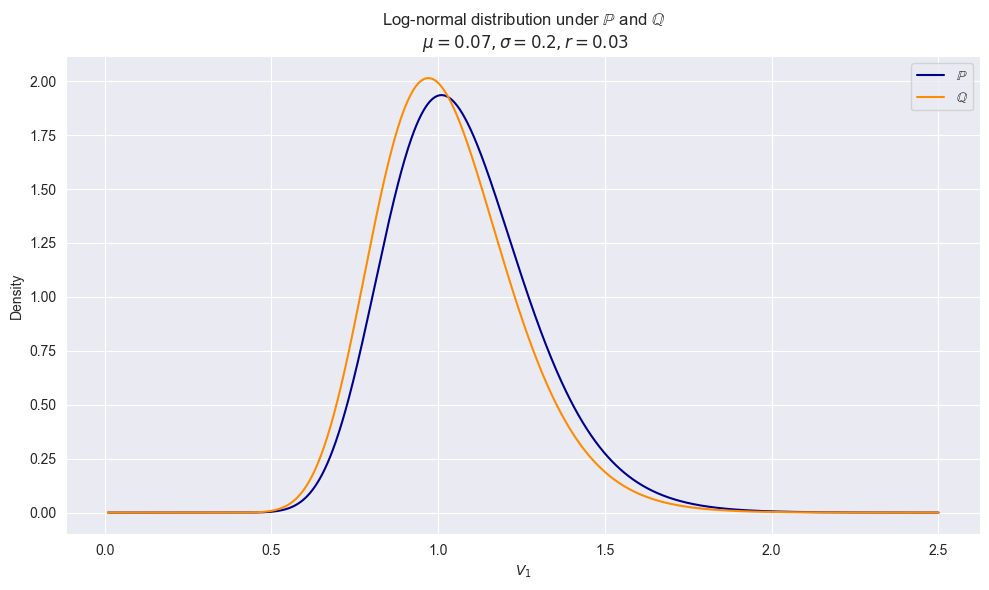

In [57]:

# define parameters
mu = 0.07 # expected return under P-measure
sigma = 0.2 # volatility
r = 0.03 # risk-free rate
lam = (mu - r) / sigma # market price of risk

# define P and Q distribution
log_norm_p = stats.lognorm(s=sigma, scale=np.exp(mu - 0.5 * sigma**2))
log_norm_q = stats.lognorm(s=sigma, scale=np.exp(r - 0.5 * sigma**2))  # or stats.lognorm(s=sigma, scale=np.exp(mu - sigma*lam - 0.5 * sigma**2))

# define range of x values
x = np.linspace(0.01, 2.5, 1000)
pdf_p = log_norm_p.pdf(x)
pdf_q = log_norm_q.pdf(x)

# plot the two distributions
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(x, pdf_p, label='$\\mathbb{P}$', color='darkblue')
plt.plot(x, pdf_q, label='$\\mathbb{Q}$', color='darkorange')
plt.title('Log-normal distribution under $\\mathbb{P}$ and $\\mathbb{Q}$ \n $\\mu = 0.07, \\sigma = 0.2, r = 0.03$')
plt.xlabel('$V_1$')
plt.ylabel('Density')
plt.legend()

# save figure
plt.tight_layout()
plt.savefig('change_of_measure_gbm.png', dpi=300)

plt.show()

## Fixed income

### Vasicek model

The [Vasicek model](https://en.wikipedia.org/wiki/Vasicek_model) of [Vasicek (1977)](https://www.sciencedirect.com/science/article/abs/pii/0304405X77900162?via%3Dihub) specifies the full yield curve in terms of a single state variable namely the short rate. It is assumed that the short rate, $Y_t$ follows an Ornstein-Uhlenbeck process

$$
dY_t = \kappa [\theta^\mathbb{Q} - Y_t] dt + \beta dW_t^\mathbb{Q}
$$

where $^\mathbb{Q}$ indicates that the dynamics are specified under the real-world probability measure. $\kappa, \theta^\mathbb{Q}$ and $\beta$ are positive constants. We can think of $\theta$ as the long-run level for the short rate. The short rate will be mean-reverting to $\theta$ such that if $r_t > \theta$ the drift term will be negative. $\kappa$ is the speed of adjustment.

In the Vasicek model, the price of a zero-coupon bond with maturity $t + \tau$ at time $t$ is given by

$$
V_t(\tau) = e^{-a(\tau) - b(\tau) r_t}
$$

It is possible to show that for the Vasicek model

$$
\begin{align}
a(\tau) &= y_\infty [\tau - b(\tau)] + \frac{\beta^2}{4 \kappa} b(\tau)^2\\
b(\tau) &= \frac{1}{\kappa} \left(1 - e^{-\kappa \tau} \right)
\end{align}
$$

with

$$
y_\infty = \theta^\mathbb{Q} - \frac{\beta^2}{2 \kappa^2}
$$

It follows that the zero-coupon yield at time $t$ for maturity $t + \tau$ is given by

$$
Y_t(\tau) = \frac{a(\tau)}{\tau}  + \frac{b(\tau)}{\tau}Y_t = y_\infty + \frac{b(\tau)}{\tau} \left(\frac{\beta^2}{4 \kappa} b(\tau) + Y_t - y_\infty \right)
$$


In [45]:
def calculate_zero_coupon_price(time_to_maturity: Union[float, np.ndarray],
                                initial_short_rate: float,
                                kappa: float,
                                theta: float,
                                beta: float):

    y_infty = theta - beta**2 / (2 * kappa**2)

    b = 1 / kappa * (1 - np.exp(-kappa * time_to_maturity))
    a = y_infty * (time_to_maturity  - b) + beta**2 / (4 * kappa) * b**2

    return np.exp(- a - b * initial_short_rate)

def calculate_zero_coupon_yield(time_to_maturity: Union[float, np.ndarray],
                                initial_short_rate: float,
                                kappa: float,
                                theta: float,
                                beta: float):

    y_infty = theta - beta**2 / (2 * kappa**2)

    b = 1 / kappa * (1 - np.exp(-kappa * time_to_maturity))
    a = y_infty * (time_to_maturity  - b) + beta**2 / (4 * kappa) * b**2

    return a / time_to_maturity + b / time_to_maturity * initial_short_rate

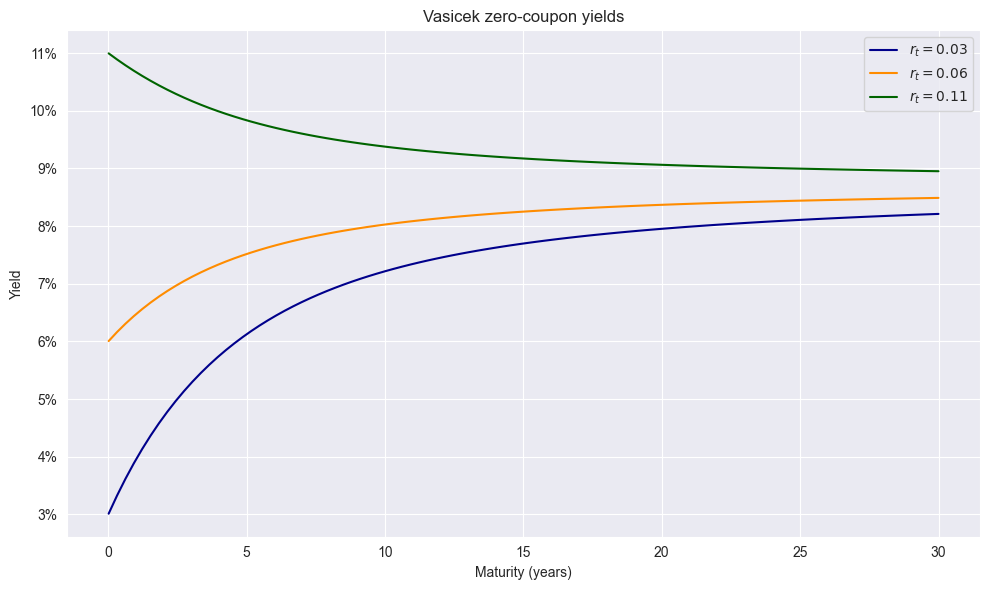

In [47]:
# define parameters
kappa = 0.36
beta = 0.0265
theta = 0.09
tenors = np.linspace(0.01, 30, 100)
initial_short_rates = [0.03, 0.06, 0.11]

color_list = ["darkblue", "darkorange", "darkgreen"]


fig, ax = plt.subplots(figsize=(10, 6))
# calculate and plot zero-coupon yields
for i, r in enumerate(initial_short_rates):
    yields = calculate_zero_coupon_yield(tenors, r, kappa, theta, beta)
    plt.plot(tenors, yields, label=f'$r_t = {r:.2f}$', color=color_list[i])

plt.title('Vasicek zero-coupon yields')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.legend()

# format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

# save figure
plt.tight_layout()
plt.savefig('vasick_zero_yields.png', dpi=300)
plt.show()
plt.close()
